## Importing Packages & Loading the Data

In [1]:
#importing packages

import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [65]:
#!pip install fbprophet

In [3]:
#read in all datasets

#median rent asking price for studio, 1br and 3br+
rent_studio = pd.read_csv('csvs/medianAskingRent_Studio.csv')
rent_1br = pd.read_csv('csvs/medianAskingRent_OneBd.csv')
rent_3br_plus = pd.read_csv('csvs/medianAskingRent_ThreePlusBd.csv')

#inventory for studio, 1br and 3br+
inv_studio = pd.read_csv('csvs/rentalInventory_Studio.csv')
inv_1br = pd.read_csv('csvs/rentalInventory_OneBd.csv')
inv_3br_plus = pd.read_csv('csvs/rentalInventory_ThreePlusBd.csv')

In [6]:
#We'll be using rent data from 2015 to May 2020

rent_studio.head(3)

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05
0,All Downtown,Manhattan,submarket,2350.0,2300.0,2200.0,2263.0,2300.0,2300.0,2290.0,...,2900.0,2950.0,2995.0,3000.0,3000.0,3000.0,3000.0,2999.0,2936.0,2850.0
1,All Midtown,Manhattan,submarket,2000.0,1995.0,1995.0,2000.0,2000.0,2000.0,2050.0,...,2699.0,2700.0,2695.0,2700.0,2700.0,2700.0,2760.0,2800.0,2795.0,2695.0
2,All Upper East Side,Manhattan,submarket,1750.0,1750.0,1750.0,1780.0,1800.0,1750.0,1750.0,...,2150.0,2150.0,2150.0,2195.0,2275.0,2250.0,2250.0,2267.0,2300.0,2225.0


In [7]:
#transpose dataset, rename columns, change index to datetime object

#studio
studio_df = rent_studio.T
studio_df.columns = rent_studio.iloc[:,0]
studio_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
studio_df.index = pd.to_datetime(studio_df.index)

#1br
onebr_df = rent_1br.T
onebr_df.columns = rent_1br.iloc[:,0]
onebr_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
onebr_df.index = pd.to_datetime(onebr_df.index)

#3br+
threebr_df = rent_3br_plus.T
threebr_df.columns = rent_3br_plus.iloc[:,0]
threebr_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
threebr_df.index = pd.to_datetime(threebr_df.index)

## Overview of Neighborhoods

Neighborhoods:

- Astoria
- Greenpoint
- Woodside

In [8]:
#filter dataframes | we only want 2015-2020 rental data of the three neighborhoods mentioned above

agw_studios = studio_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]
agw_1br = onebr_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]
agw_3br = threebr_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]

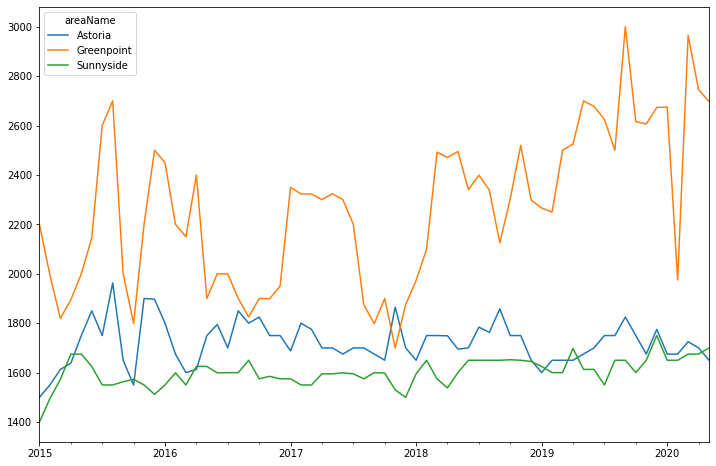

In [9]:
#rental data for studios across 5 years

agw_studios.plot(figsize=(12,8))

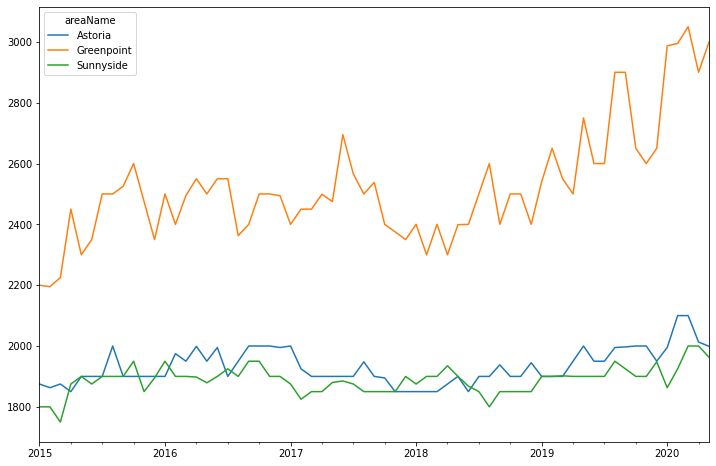

In [279]:
#rental data for one bedrooms across 5 years
agw_1br[['Astoria', 'Greenpoint', 'Sunnyside']].plot(figsize=(12,8))

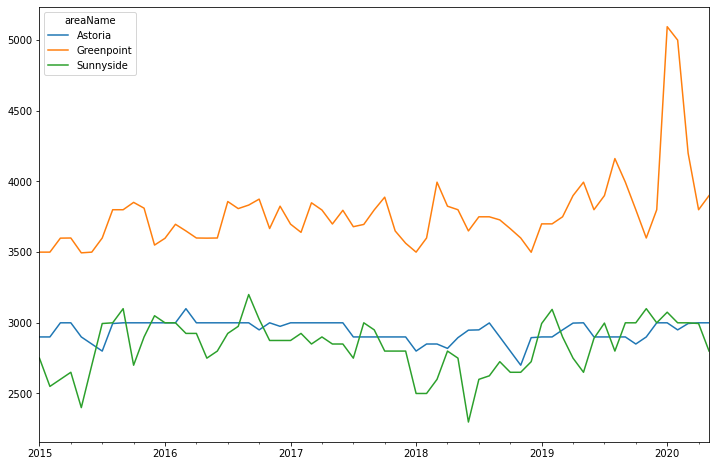

In [280]:
#rental data for three bedrooms+ across 5 years
agw_3br[['Astoria', 'Greenpoint', 'Sunnyside']].plot(figsize=(12,8))

## Distribution of Rental Data Across Neighborhoods & Rental Types

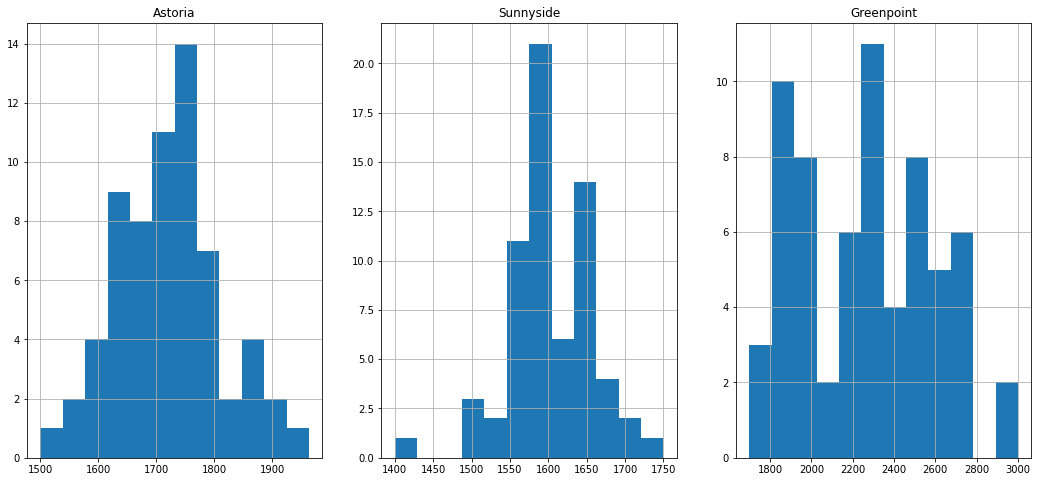

In [284]:
#studios median rent distribution

fig, (ax,ax2,ax3) = plt.subplots(1,3, figsize=(18,8))
agw_studios['Astoria'].hist(ax=ax, bins=12)
ax.set_title('Astoria')
agw_studios['Sunnyside'].hist(ax=ax2, bins=12)
ax2.set_title('Sunnyside')
agw_studios['Greenpoint'].hist(ax=ax3, bins=12)
ax3.set_title('Greenpoint')
plt.show()

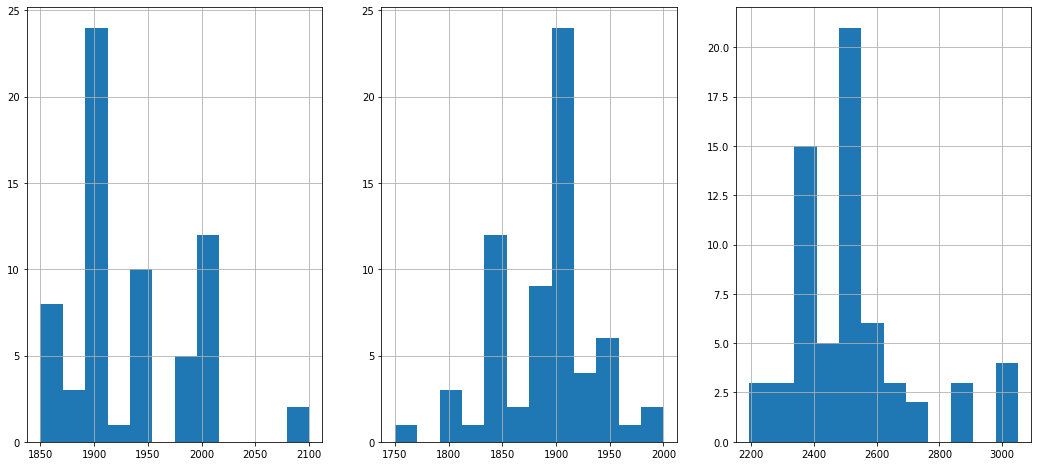

In [285]:
#one bedrooms median rent distribution

fig2, (ax4,ax5,ax6) = plt.subplots(1,3, figsize=(18,8))
agw_1br['Astoria'].hist(ax=ax4, bins=12)
ax.set_title('Astoria')
agw_1br['Sunnyside'].hist(ax=ax5, bins=12)
ax2.set_title('Sunnyside')
agw_1br['Greenpoint'].hist(ax=ax6, bins=12)
ax3.set_title('Greenpoint')
plt.show()

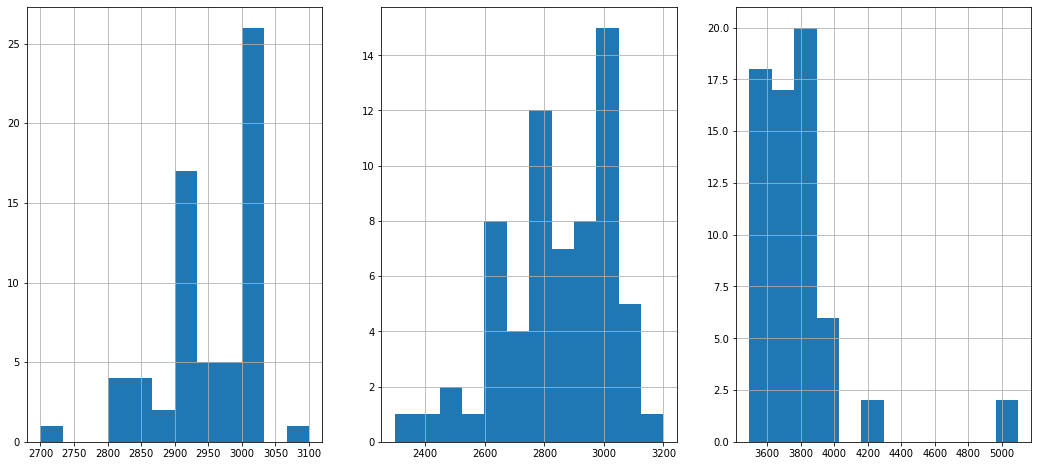

In [286]:
#three bedrooms+ median rent distribution

fig3, (ax7,ax8,ax9) = plt.subplots(1,3, figsize=(18,8))
agw_3br['Astoria'].hist(ax=ax7, bins=12)
ax.set_title('Astoria')
agw_3br['Sunnyside'].hist(ax=ax8, bins=12)
ax2.set_title('Sunnyside')
agw_3br['Greenpoint'].hist(ax=ax9, bins=12)
ax3.set_title('Greenpoint')
plt.show()

## Astoria 

### Studios

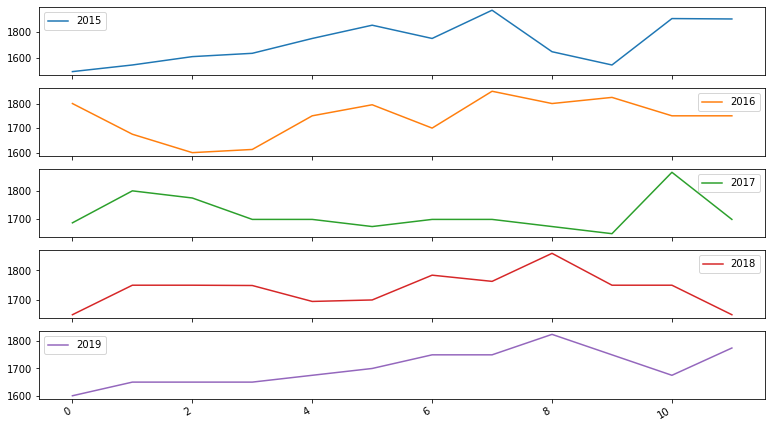

In [12]:
# Use pandas grouper to group values using annual frequency
year_groups_a = agw_studios['2015':'2019'][['Astoria']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
studios_annual_a = pd.DataFrame()

for yr, group in year_groups_a:
    studios_annual_a[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
studios_annual_a.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#studios_annual.plot(figsize = (15,5), subplots=False, legend=True);

### Rolling Statistics

In [13]:
roll_mean_a = agw_studios[['Astoria']].rolling(window=8, center=False).mean()
roll_std_a = agw_studios[['Astoria']].rolling(window=8, center=False).std()

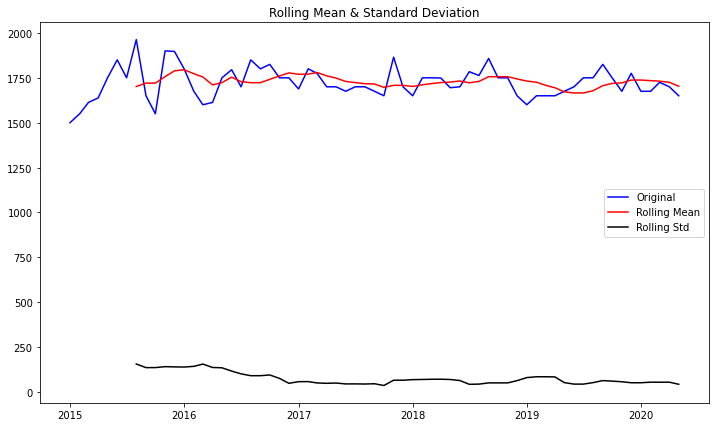

In [14]:
fig = plt.figure(figsize=(12,7))
plt.plot(agw_studios[['Astoria']], color='blue', label='Original')
plt.plot(roll_mean_a, color='red', label='Rolling Mean')
plt.plot(roll_std_a, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [15]:
#dickeyfuller test for Astoria Studios

dftest_a = adfuller(agw_studios[['Astoria']])

# Extract and display test results in a user friendly manner
dfoutput_a = pd.Series(dftest_a[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_a[4].items():
    dfoutput_a['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_a)

Results of Dickey-Fuller test: 

Test Statistic                -5.932292e+00
p-value                        2.365005e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.400000e+01
Critical Value (1%)           -3.536928e+00
Critical Value (5%)           -2.907887e+00
Critical Value (10%)          -2.591493e+00
dtype: float64


### ACF & PACF

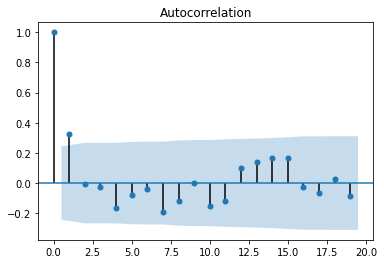

In [17]:
plot_acf(agw_studios['Astoria']);

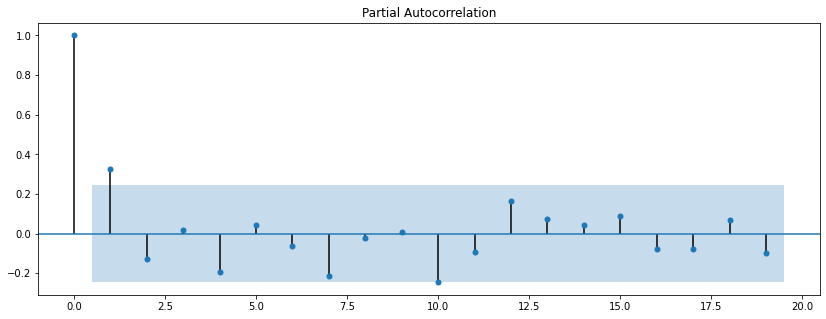

In [287]:
plot_pacf(agw_studios['Astoria']);

## BASELINE MODEL

In [69]:
astoria_studios = agw_studios[['Astoria']]

In [33]:
# Create lagged dataset
values = pd.DataFrame(astoria_studios.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

    t-1   t+1
0   NaN  1500
1  1500  1550
2  1550  1613
3  1613  1638
4  1638  1750


In [42]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.75)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [43]:
# persistence model
def model_persistence(x):
    return x

In [44]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test RMSE: %.3f' % sqrt(test_score))

Test RMSE: 54.906


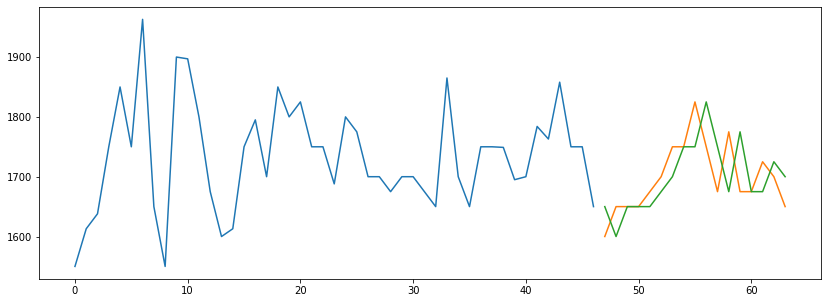

In [45]:
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

## ARIMA MODEL

In [20]:
#np.asarray(agw_studios['Astoria'])

In [23]:
#model

#fit ARIMA model (3,1,0))

model = ARIMA(np.asarray(agw_studios['Astoria']), order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   65
Model:                     ARMA(1, 1)   Log Likelihood                -377.718
Method:                       css-mle   S.D. of innovations             80.682
Date:                Fri, 26 Jun 2020   AIC                            763.436
Time:                        07:37:32   BIC                            772.133
Sample:                             0   HQIC                           766.868
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1719.9400     13.541    127.021      0.000    1693.401    1746.479
ar.L1.y       -0.1291      0.359     -0.360      0.719      -0.832       0.574
ma.L1.y        0.5310      0.316      1.681      0.0

predicted=1691.453259, expected=1600.000000
predicted=1699.166284, expected=1650.000000
predicted=1709.364194, expected=1650.000000
predicted=1700.082407, expected=1650.000000
predicted=1702.427382, expected=1675.000000
predicted=1709.996584, expected=1700.000000
predicted=1716.109492, expected=1750.000000
predicted=1734.430600, expected=1750.000000
predicted=1726.222193, expected=1825.000000
predicted=1763.485655, expected=1750.000000
predicted=1715.853710, expected=1675.000000
predicted=1706.204342, expected=1775.000000
predicted=1752.302406, expected=1675.000000
predicted=1688.530013, expected=1675.000000
predicted=1721.009621, expected=1725.000000
predicted=1723.288035, expected=1700.000000
predicted=1712.031684, expected=1650.000000
Test RMSE: 51.997


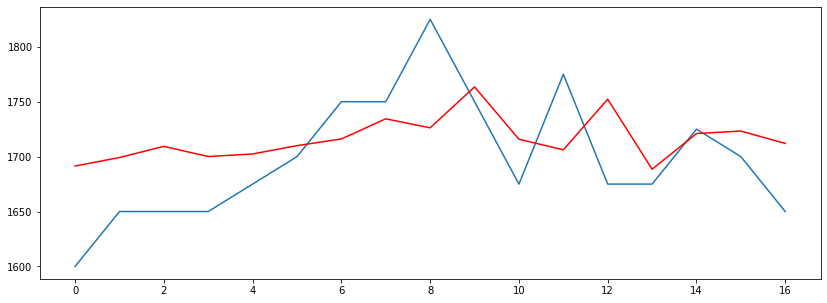

In [204]:
#trying from blog

X = agw_studios[['Astoria']].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % sqrt(error))
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [47]:
#len(test)

In [46]:
#model_fit.forecast(steps=24)[0]

## FB PROPHET

In [ ]:
astoria_studios.reset_index(inplace=True)
#astoria_studios.index.rename('', inplace=True)
astoria_studios.rename(columns={'index': 'ds', 'Astoria': 'y'}, inplace=True)

In [277]:
astoria_studios.head()

areaName,ds,y
0,2015-01-01,1500
1,2015-02-01,1550
2,2015-03-01,1613
3,2015-04-01,1638
4,2015-05-01,1750


In [270]:
# Train/Split
tss_astoria_studios = TimeSeriesSplit(n_splits = 2)

X_a_studios = astoria_studios['ds'].values
y_a_studios = astoria_studios['y'].values

X_train = X_a_studios[:int(X.shape[0]*0.75)]
X_test = X_a_studios[int(X.shape[0]*0.75):]
y_train = y_a_studios[:int(X.shape[0]*0.75)]
y_test = y_a_studios[int(X.shape[0]*0.75):]

ast_studio_train = pd.DataFrame(y_train,index = X_train, columns = ['y'])
ast_studio_test = pd.DataFrame(y_test, index = X_test, columns = ['y'])
ast_studio_train.head()
ast_studio_train.reset_index(inplace = True)
ast_studio_train.rename(columns = {'index':'ds'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE in $$:  85.64278297347646


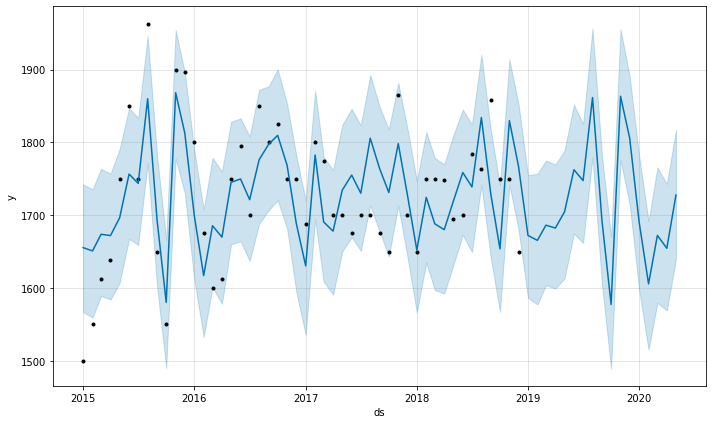

In [276]:
ast_studios_prophet = Prophet().fit(ast_studio_train)

future_ast_studios = ast_studios_prophet.make_future_dataframe(periods=17,freq = 'MS')
forecast_ast_studios = ast_studios_prophet.predict(future_ast_studios)
forecast_ast_studios.tail()

fig1_ast_studios = ast_studios_prophet.plot(forecast_ast_studios)

preds_ast_studios = forecast_ast_studios[48:][['ds','yhat']].set_index('ds')
preds_ast_studios.head()

preds_ast_studios_df = pd.concat([ast_studio_test ,preds_ast_studios],axis = 1)
preds_ast_studios_df.head()

error = np.sqrt(sum((preds_ast_studios_df['y'] - preds_ast_studios_df['yhat'])**2)/len(preds_ast_studios_df))
print('RMSE in $$: ', error)


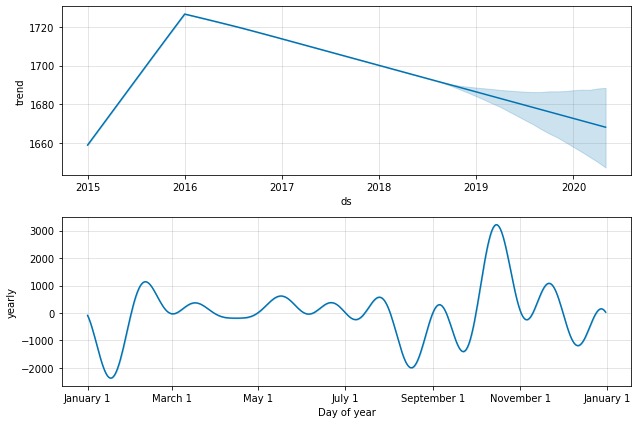

In [278]:
fig2_ast_studios = ast_studios_prophet.plot_components(forecast)

### One Bedroom

## Greenpoint Studios

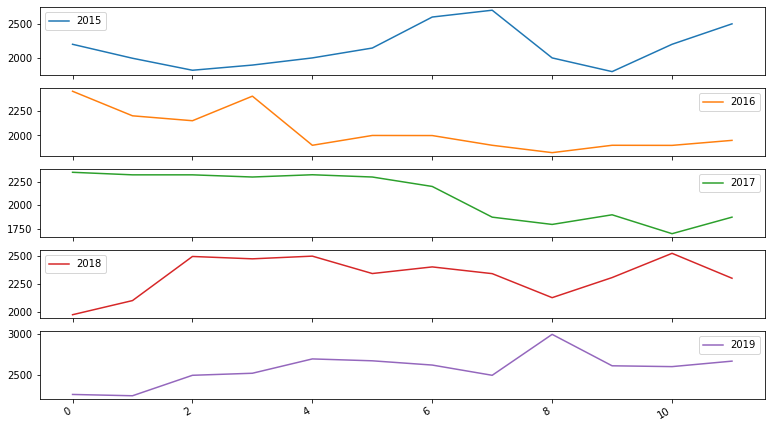

In [262]:
# Use pandas grouper to group values using annual frequency
year_groups_gp = agw_studios['2015':'2019'][['Greenpoint']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
studios_annual_gp = pd.DataFrame()

for yr, group in year_groups_gp:
    studios_annual_gp[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
studios_annual_gp.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#studios_annual.plot(figsize = (15,5), subplots=False, legend=True);

Rolling Statistics

In [263]:
roll_mean_gp = agw_studios[['Greenpoint']].rolling(window=8, center=False).mean()
roll_std_gp = agw_studios[['Greenpoint']].rolling(window=8, center=False).std()

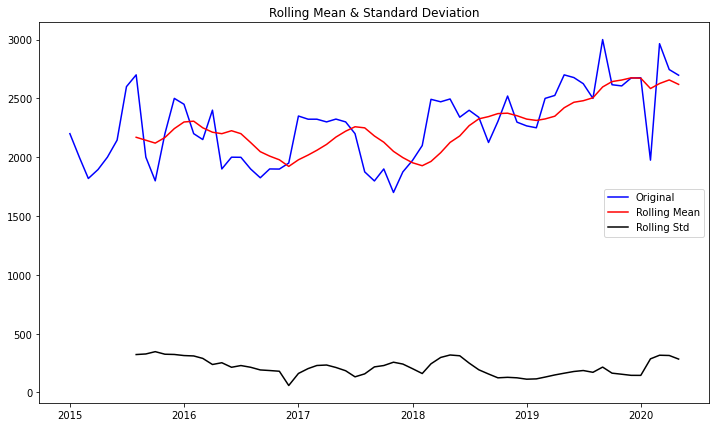

In [264]:
fig = plt.figure(figsize=(12,7))
plt.plot(agw_studios[['Greenpoint']], color='blue', label='Original')
plt.plot(roll_mean_gp, color='red', label='Rolling Mean')
plt.plot(roll_std_gp, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [266]:
#dickeyfuller test for Greenpoint Studios

dftest_gp = adfuller(agw_studios[['Greenpoint']])

# Extract and display test results in a user friendly manner
dfoutput_gp = pd.Series(dftest_gp[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_gp[4].items():
    dfoutput_gp['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_gp)

Results of Dickey-Fuller test: 

Test Statistic                 -2.845670
p-value                         0.052040
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [278]:
#differencing

gp_studio_diff = agw_studios[['Greenpoint']].diff(periods=1)
gp_studio_diff.dropna(inplace=True)

In [279]:
#dickeyfuller test for Sunnyside Studios after differencing

dftest_gp_diff = adfuller(gp_studio_diff)

# Extract and display test results in a user friendly manner
dfoutput_gp_diff = pd.Series(dftest_gp_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_gp_diff[4].items():
    dfoutput_gp_diff['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_gp_diff)

Results of Dickey-Fuller test: 

Test Statistic                 -4.206858
p-value                         0.000642
#Lags Used                      8.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


ACF & PACF

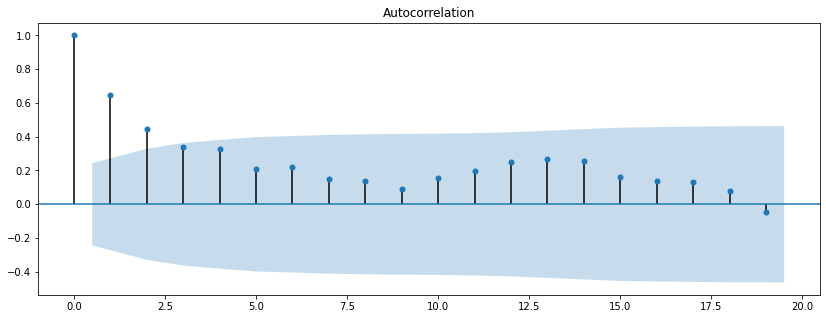

In [287]:
plot_acf(agw_studios['Greenpoint']);

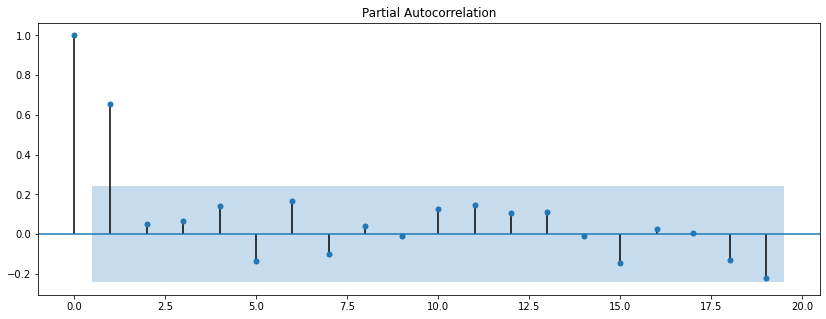

In [288]:
plot_pacf(agw_studios['Greenpoint']);

## Sunnyside Studios

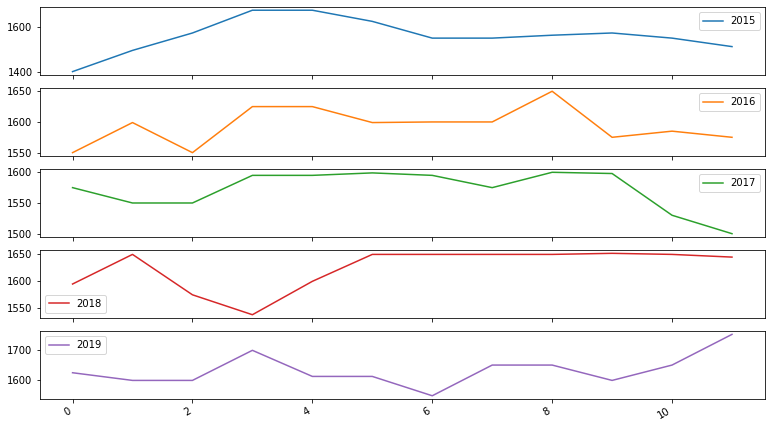

In [267]:
# Use pandas grouper to group values using annual frequency
year_groups_s = agw_studios['2015':'2019'][['Sunnyside']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
studios_annual_s = pd.DataFrame()

for yr, group in year_groups_s:
    studios_annual_s[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
studios_annual_s.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#studios_annual.plot(figsize = (15,5), subplots=False, legend=True);

Rolling Statistics

In [268]:
roll_mean_s = agw_studios[['Sunnyside']].rolling(window=8, center=False).mean()
roll_std_s = agw_studios[['Sunnyside']].rolling(window=8, center=False).std()

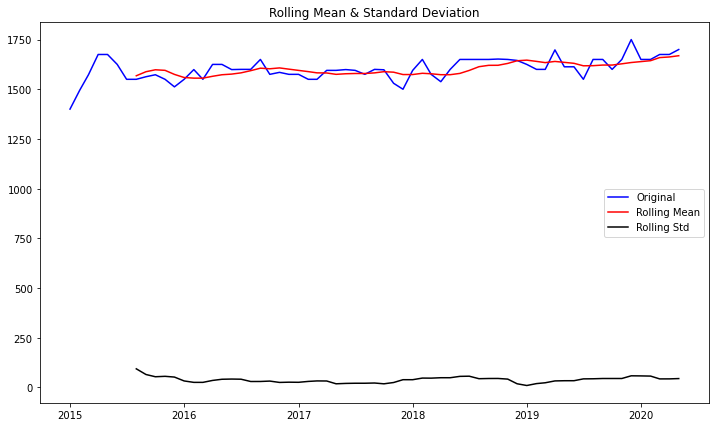

In [269]:
fig = plt.figure(figsize=(12,7))
plt.plot(agw_studios[['Sunnyside']], color='blue', label='Original')
plt.plot(roll_mean_s, color='red', label='Rolling Mean')
plt.plot(roll_std_s, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [271]:
#dickeyfuller test for Sunnyside Studios

dftest_s = adfuller(agw_studios[['Sunnyside']])

# Extract and display test results in a user friendly manner
dfoutput_s = pd.Series(dftest_s[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_s[4].items():
    dfoutput_s['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_s)

Results of Dickey-Fuller test: 

Test Statistic                 -1.796457
p-value                         0.382222
#Lags Used                      3.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [276]:
#differencing

s_studio_diff = agw_studios[['Sunnyside']].diff(periods=1)
s_studio_diff.dropna(inplace=True)

In [277]:
#dickeyfuller test for Sunnyside Studios after differencing

dftest_s = adfuller(s_studio_diff)

# Extract and display test results in a user friendly manner
dfoutput_s = pd.Series(dftest_s[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_s[4].items():
    dfoutput_s['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_s)

Results of Dickey-Fuller test: 

Test Statistic                -8.175901e+00
p-value                        8.379023e-13
#Lags Used                     2.000000e+00
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64


ACF & PACF

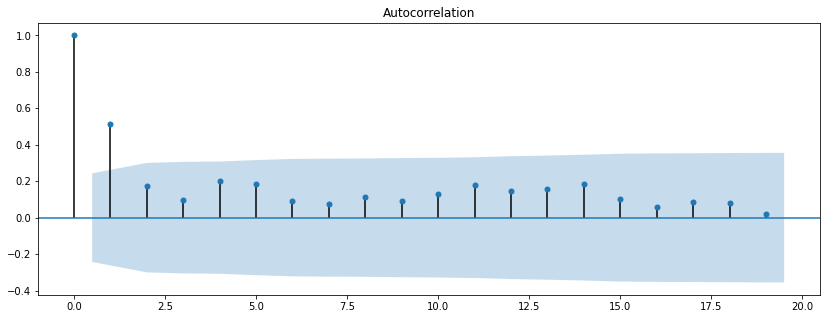

In [289]:
plot_acf(agw_studios['Sunnyside']);

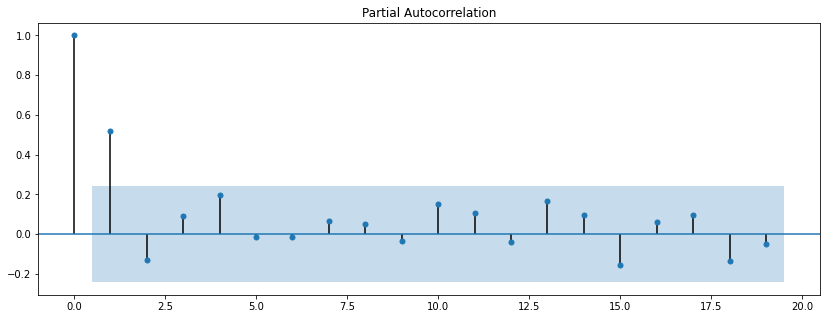

In [290]:
plot_pacf(agw_studios['Sunnyside']);

In [176]:
#studio_df, onebr_df, threebr_df

#studio_df[['Astoria', 'Greenpoint', 'Sunnyside']].plot(figsize=(12,8))

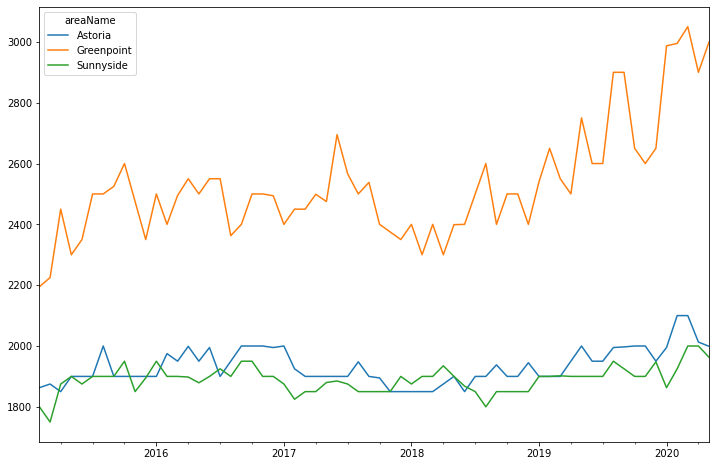

In [177]:
#onebr_df[['Astoria', 'Greenpoint', 'Sunnyside']].plot(figsize=(12,8))

onebr_df.iloc[61:][['Astoria', 'Greenpoint', 'Sunnyside']].plot(figsize=(12,8))

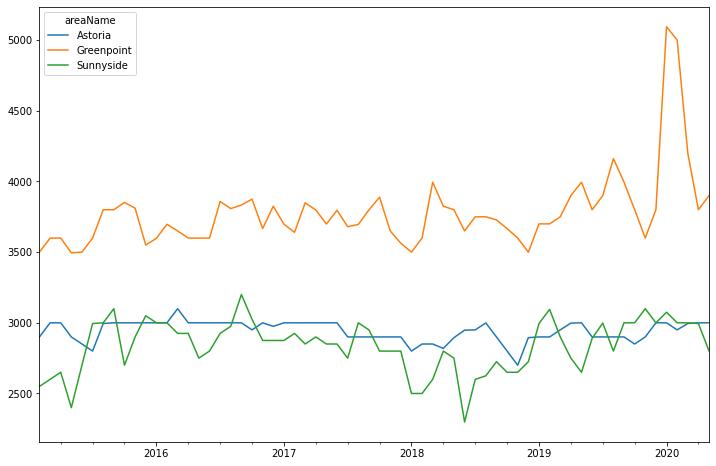

In [178]:
#threebr_df[['Astoria', 'Greenpoint', 'Sunnyside']].plot(figsize=(12,8))

threebr_df.iloc[61:][['Astoria', 'Greenpoint', 'Sunnyside']].plot(figsize=(12,8))

In [182]:
studio_df.iloc[61:][['Astoria', 'Greenpoint', 'Sunnyside']].isna().sum()

areaName
Astoria       0
Greenpoint    0
Sunnyside     0
dtype: int64

In [255]:
#filling in missing data for Astoria

#studio

#studio_df[studio_df['Astoria'].isna() == True]['Astoria']